# 📊 Model Evaluation & Interpretation

AquaSafe — Water Quality Classification

### 🎯 Objective

This notebook performs final evaluation and interpretation of trained models for water quality classification.

Goals:

- Evaluate model performance on unseen test data

- Analyze per-class behavior and failure modes

- Interpret feature importance using domain context

- Validate robustness under class imbalance

- Document limitations and future improvements

> ⚠️ No training, resampling, or preprocessing occurs in this notebook.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import joblib

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


from sklearn.model_selection import train_test_split

In [2]:
from utils.config import DATA_DIR
from src.data_preprocessing.create_dataframe import create_dataframe
from utils.visualization import visualize_chart, plot_functions

### Load Artifacts


In [3]:
MODELS_DIR = Path("../models/")

best_model_name = (MODELS_DIR / "best_model_name.txt").read_text().strip()
model = joblib.load(MODELS_DIR / f"{best_model_name.lower()}_pipeline.pkl")
label_encoder = joblib.load(MODELS_DIR / "label_encoder.pkl")
feature_names = joblib.load(MODELS_DIR / "feature_names.pkl")

print(f"✓ Loaded best model: {best_model_name}")
print(f"✓ Number of features: {len(feature_names)}")


✓ Loaded best model: LogisticRegression
✓ Number of features: 179


In [4]:
DATA_PATH = os.path.join(DATA_DIR, "processed", "csv", "nwmp_features_v1.csv")

df = create_dataframe(DATA_PATH)

print(f"✓ Loaded feature dataset: {df.shape}")

✓ Loaded feature dataset: (171, 180)


In [5]:
TARGET_COL = "use_based_class"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

y_encoded = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print(f"✓ Test set size: {X_test.shape[0]}")


✓ Test set size: 35


### 🧪 Final Test Set Evaluation

In [6]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
}

metrics


{'accuracy': 0.9714285714285714,
 'f1_macro': 0.9600484261501211,
 'precision_macro': 0.9916666666666667,
 'recall_macro': 0.9375}

In [7]:
print(
    classification_report(
        y_test,
        y_pred,
        target_names=label_encoder.classes_,
        digits=4,
        zero_division=0
    )
)

              precision    recall  f1-score   support

           A     0.9667    1.0000    0.9831        29
           B     1.0000    1.0000    1.0000         1
           C     1.0000    1.0000    1.0000         1
           E     1.0000    0.7500    0.8571         4

    accuracy                         0.9714        35
   macro avg     0.9917    0.9375    0.9600        35
weighted avg     0.9724    0.9714    0.9696        35



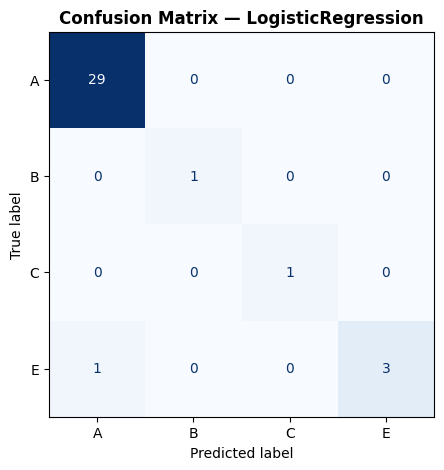

In [8]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title(f"Confusion Matrix — {best_model_name}", fontweight="bold")
ax.grid(False)
plt.show()


In [9]:
# ============================================================================
# FEATURE INTERPRETATION: LOGISTIC REGRESSION COEFFICIENTS
# ============================================================================

# Extract trained logistic regression model
log_reg = model.named_steps["model"]

# Get coefficients
coef = log_reg.coef_

# For multiclass: average absolute coefficient across classes
coef_mean = np.mean(np.abs(coef), axis=0)

feature_names = joblib.load(MODELS_DIR / "feature_names.pkl")

coef_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Coefficient_Importance": coef_mean
    })
    .sort_values("Coefficient_Importance", ascending=False)
    .head(20)
)

display(coef_df)


,Feature,Coefficient_Importance
143,approx_depth_Less than 50cm,0.484757
160,human_activities_Others,0.390478
142,approx_depth_Greater than 100cm,0.320196
136,district_Solapur,0.316117
25,phosphate,0.315102
127,district_Nagpur,0.314668
4,conductivity,0.294651
141,approx_depth_50-100cm,0.261560
28,flouride,0.254248
12,total_alkalinity,0.237782


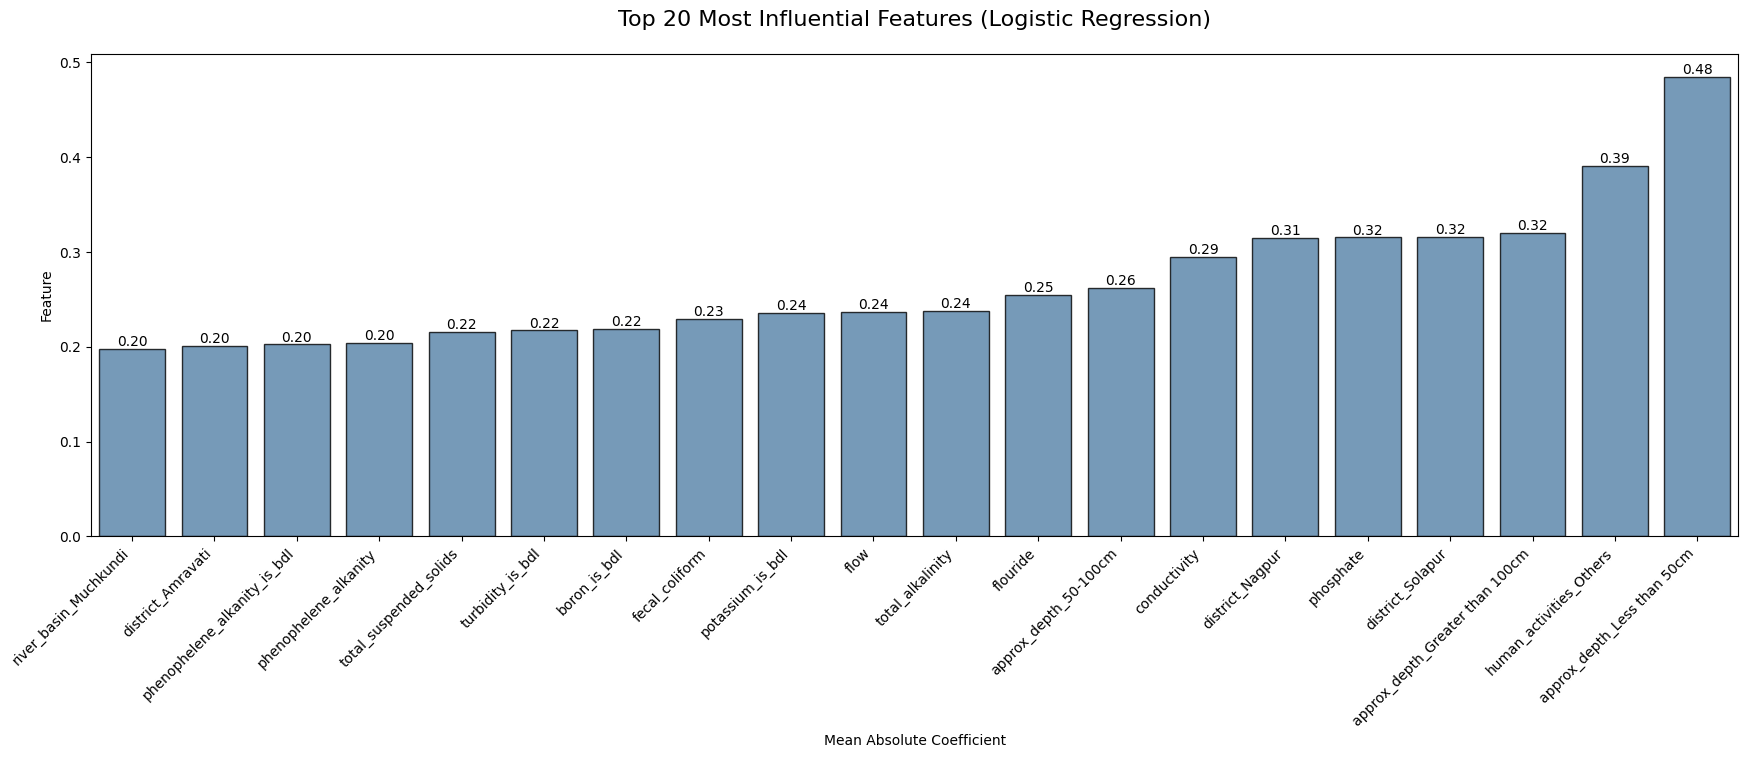

In [27]:
# Plot top 20 most influential features
chart_object = [{
    "plot_function": plot_functions["bar"],
    "title": "Top 20 Most Influential Features (Logistic Regression)",
    "xlabel": "Mean Absolute Coefficient",
    "ylabel": "Feature",
    "x": coef_df["Feature"][::-1],
    "y": coef_df["Coefficient_Importance"][::-1],
    "kwargs": {
        "color": "steelblue",
        "edgecolor": "black",
        "alpha": 0.8,
    }
}]

visualize_chart(chart_object, nrows=1, ncols=1)

plt.xticks(rotation=45, ha="right")
plt.show()
